In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from collections import Counter
import string
import re

# Import user defined functions.
import parse as prs
import helper as hlp

# Read and parse json.
df = pd.read_json('data/train.json')

# Defining names of the target
target_names = ['high','medium','low']

In [2]:
# Reducing the dataframe
#rows = np.random.choice(df.index.values, 1000)
#sampled_df = df.ix[rows]
#df = sampled_df

In [3]:
# Looking at the dataframe
rows = np.random.choice(df.index.values, 3)
sampled_df = df.ix[rows]
sampled_df

bathrooms  bedrooms                       building_id  \
30148        1.0         3  1f31e9001330dad4c202f92dc8ab8724   
89192        1.0         2  0095cb49c423ec7b204e26d76c56bd35   
19714        1.0         1  2f0e2593ea87578d8b7e41f7e4210032   

                   created                                        description  \
30148  2016-06-16 08:04:43  Remarkable Apartment with Great bedrooms, amaz...   
89192  2016-04-06 08:07:02                                                      
19714  2016-06-01 01:38:53  Brand New Elevator Building on Bowery. Two uni...   

         display_address                                           features  \
30148   East 66th Street                              [Laundry in Building]   
89192  Macdonough Street                                                 []   
19714            Bowery   [Elevator, Dishwasher, Laundry in Unit, Hardwo...   

      interest_level  latitude  listing_id  longitude  \
30148            low   40.7640     7172737   -73.9591   
89192           high   40.6834     6834215   -73.9208   
19714            low   40.7199     7087953   -73.9938   

                             manager_id  \
30148  aea47aba66a01cf236746e209c2b7f88   
89192  784d60d6d44f3529218aef847d0d897d   
19714  04893370919d5fe1a0a25dc25b6db529   

                                                  photos  price  \
30148  [https://photos.renthop.com/2/7172737_1b80dae7...   4350   
89192  [https://photos.renthop.com/2/6834215_17cdf746...   1850   
19714  [https://photos.renthop.com/2/7087953_bd116823...   4445   

              street_address  
30148   354 East 66th Street  
89192  640 MacDonough Street  
19714            169 Bowery

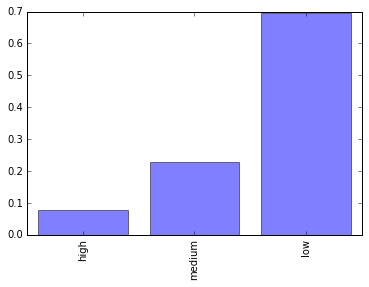

In [4]:
# Proportion of interest level.
prop_interest = []
for interest_name in target_names:
   prop_interest.append(np.float(np.sum(df.interest_level==interest_name))/np.float(np.shape(df)[0]))

# Plotting as graph bar.
y_pos = np.arange(len(target_names))
plt.bar(y_pos, prop_interest, align='center', alpha=0.5)
plt.xticks(y_pos, target_names, rotation='vertical') 
plt.show()

In [5]:
# Looking at the most common features in an subset
size_subset = 100
n_features = 10
rows = np.random.choice(df.index.values, size_subset)
sampled_features = df["features"].ix[rows]
allFeatures=[]
for row in rows:
    allFeatures.extend(sampled_features.loc[[row]].values[0])
     #   allFeatures.extend(map(lambda x:x.lower(),sampled_features.loc[[row]].values[0]))
features_to_count = (word for word in allFeatures if word[:1])
features_count = Counter(features_to_count)
common_features = map(lambda x:x[0],features_count.most_common(n_features))
common_features_rows= map(lambda x:'with_'+x.lower().replace(" ","_"),common_features)
print(common_features_rows)

[u'with_elevator', u'with_hardwood_floors', u'with_dogs_allowed', u'with_cats_allowed', u'with_doorman', u'with_dishwasher', u'with_no_fee', u'with_laundry_in_building', u'with_fitness_center', u'with_laundry_in_unit']


In [6]:
# Looking at the most common words in description in an subset
size_subset = 1000
n_keywords = 50
rows = np.random.choice(df.index.values, size_subset)
sampled_descriptions = df["description"].ix[rows]
allDescriptionsKeywords=[]
for row in rows:
    desc = sampled_descriptions.loc[[row]].values[0]

    #Add space before upper-case
    desc = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ',desc)

    #Replace char with space
    repls = (',', ' '), ('#', ' '), ('.', ' '), ('-', ' '), ('\'', ' '), ('!', ' ')
    desc = reduce(lambda a, kv: a.replace(*kv), repls, desc.lower())

    #Remove all non letters 
    whitelist = set(string.letters+' ,')
    desc = ''.join(filter(whitelist.__contains__,desc))

    #Remove small words
    desc = ' '.join(word for word in desc.split() if len(word)>4)

    allDescriptionsKeywords.extend(desc.split(' '))

keywords_to_count = (word for word in allDescriptionsKeywords if word[:1])

keywords_count = Counter(keywords_to_count)
common_keywords = map(lambda x:x[0],keywords_count.most_common(n_keywords))

print(common_keywords)
# What can we do with that? not much...

[u'apartment', u'websiteredacted', u'building', u'kitchen', u'bedroom', u'appliances', u'space', u'floors', u'hardwood', u'kagglemanagerrenthop', u'renovated', u'large', u'stainless', u'features', u'laundry', u'located', u'great', u'steel', u'contact', u'living', u'bathroom', u'windows', u'email', u'beautiful', u'marble', u'doorman', u'restaurants', u'granite', u'location', u'closet', u'private', u'floor', u'spacious', u'cooper', u'access', u'dishwasher', u'studio', u'elevator', u'ceilings', u'viewing', u'luxury', u'views', u'central', u'light', u'information', u'broker', u'amenities', u'estate', u'center', u'please']


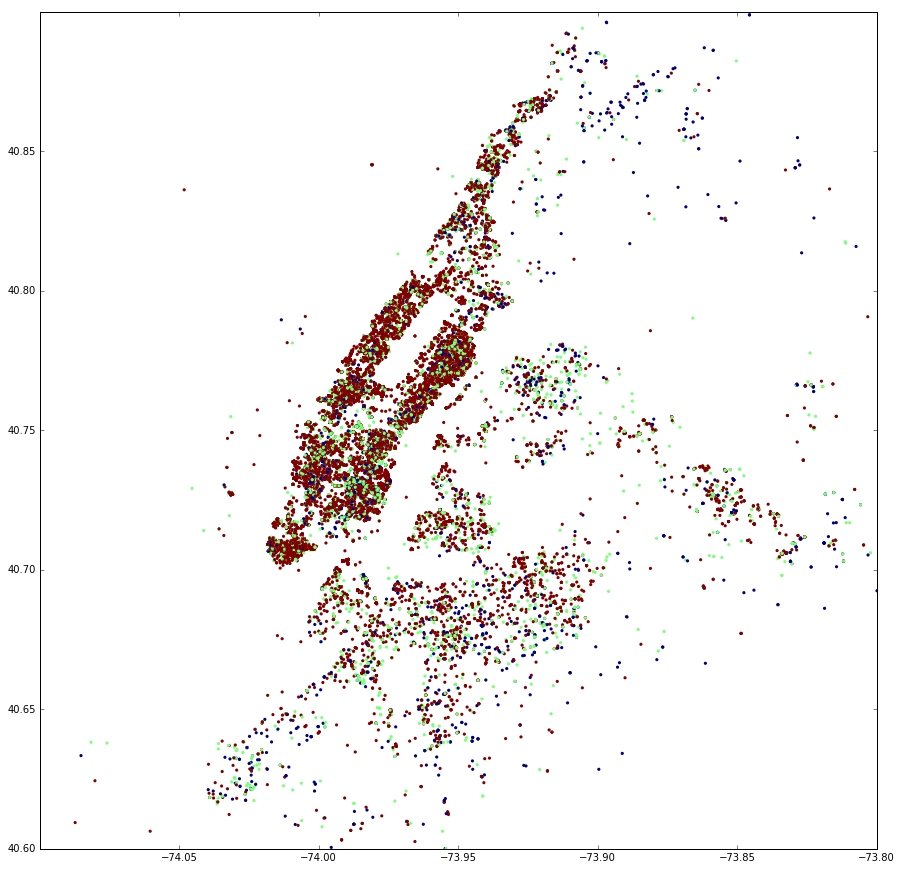

In [7]:
# Looking at the position vs interest

df_sample = pd.DataFrame(df, columns=["longitude","latitude","interest_level"])
df_sample["interest_level_num"] = map(lambda x:hlp.interest_level2numeral(x),df_sample["interest_level"])

# scatter plot position 2D vs interest lvl.
plt.figure(figsize=(15, 15))
plt.scatter(df_sample["longitude"].values,
            df_sample["latitude"].values,
            c=df_sample["interest_level_num"].values, marker='o', s=10,linewidths=0)
plt.xlim([-74.1, -73.8])
plt.ylim([40.6,40.9])
plt.show() 

In [8]:
# Parsing the dataframe
X, y = prs.parse_2(df.copy()),prs.target(df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [9]:
# Classifying
clf = RandomForestClassifier(n_estimators=200,n_jobs = 3)
clf = clf.fit(X_train, y_train)

In [10]:
# Estimating the score
y_val_pred = clf.predict_proba(X_val)
val_loss = log_loss(y_val,y_val_pred)
print(val_loss)

0.619574254203


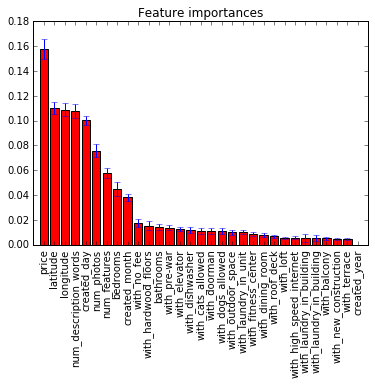

In [11]:
# Analyzing the forest features importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]),X_train.columns.values[indices], rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [12]:
# Predicting data.
df_test = pd.read_json('data/test.json')
X_test = prs.parse_2(df_test.copy())
y_test_pred = clf.predict_proba(X_test)
ids = df_test['listing_id'].values

In [13]:
# Writting the submission file
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
subm = pd.DataFrame()
subm["listing_id"] = df_test["listing_id"]
for label in ["high", "medium", "low"]:
    subm[label] = y_test_pred[:, labels2idx[label]]
subm.to_csv("submission_rf.csv", index=False)

In [88]:
# Trying a multilayer perceptron
clf = MLPClassifier(activation='relu',solver='adam', alpha=1e-6,hidden_layer_sizes=(20,15),
                    learning_rate_init=0.01, max_iter=10000,learning_rate='adaptive')
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train_sca = scaler.transform(X_train)  
clf.fit(X_train_sca, y_train)  

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 15), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [89]:
# Estimating the score
X_val_sca = scaler.transform(X_val)
y_val_pred = clf.predict_proba(X_val_sca)
val_loss = log_loss(y_val,y_val_pred)
print(val_loss)
y_train_pred = clf.predict_proba(X_train_sca)
train_loss = log_loss(y_train,y_train_pred)
print(train_loss)

0.647022468541
0.626722856086
